In [ ]:
import zipfile
import os

# Path to your zip file
zip_file_path = '/content/drive/MyDrive/Pancreas cancer/archive (2).zip'

# Directory to extract the contents into
extract_to_directory = '/content/drive/MyDrive/Pancreas cancer/Images'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_to_directory, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

print("Extraction complete.")


In [ ]:
import cv2
import os
import numpy as np

In [ ]:
def load_and_preprocess_images(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img_resized = cv2.resize(img, target_size)
            images.append(img_resized)
    return images

In [ ]:
def process_images_in_batches(folder, batch_size=32):
    processed_data = []
    for i in range(0, len(os.listdir(folder)), batch_size):
        batch_files = os.listdir(folder)[i:i+batch_size]
        batch_images = [cv2.imread(os.path.join(folder, file)) for file in batch_files if os.path.isfile(os.path.join(folder, file))]
        # Preprocess this batch of images (e.g., normalization, resizing)
        batch_preprocessed = [cv2.resize(img, (224, 224)) / 255.0 for img in batch_images if img is not None]
        processed_data.extend(batch_preprocessed)
        # Free up memory after processing
        del batch_images
        del batch_preprocessed
    return np.array(processed_data)

In [ ]:
# Paths to image directories
X_train_dir = '/content/drive/MyDrive/Pancreas cancer/Images/Dataset/X_train'
Y_train_dir = '/content/drive/MyDrive/Pancreas cancer/Images/Dataset/Y_train'
X_test_dir = '/content/drive/MyDrive/Pancreas cancer/Images/Dataset/X_test'
Y_test_dir = '/content/drive/MyDrive/Pancreas cancer/Images/Dataset/Y_test'

In [ ]:
# Load and preprocess smaller-sized images directly
X_train_resized = load_and_preprocess_images(X_train_dir, target_size=(128, 128))

In [ ]:
Y_train_resized = load_and_preprocess_images(Y_train_dir, target_size=(128, 128))

In [ ]:
X_test_resized = load_and_preprocess_images(X_test_dir, target_size=(128, 128))

In [ ]:
Y_test_resized = load_and_preprocess_images(Y_test_dir, target_size=(128, 128))

In [ ]:
# prompt: --------------------------------------------------------------------------- AttributeError                            Traceback (most recent call last) <ipython-input-15-b82a18a8d842> in <cell line: 1>() ----> 1 X_train_resized.shape  AttributeError: 'list' object has no attribute 'shape'

X_train_resized = np.array(X_train_resized)
Y_train_resized = np.array(Y_train_resized )
X_test_resized= np.array(X_test_resized)
Y_test_resized= np.array(Y_test_resized)


In [ ]:
X_train_resized.shape

(19287, 128, 128, 3)

In [ ]:
Y_train_resized.shape

(19287, 128, 128, 3)

In [ ]:
X_test_resized.shape

(3894, 128, 128, 3)

In [ ]:
Y_test_resized.shape

(3894, 128, 128, 3)

In [ ]:
print('X_train_resized shape:', X_train_resized.shape)
print('Y_train_resized shape:', Y_train_resized.shape)
print('X_test_resized shape:', X_test_resized.shape)
print('Y_test_resized shape:', Y_test_resized.shape)

X_train_resized shape: (19287, 128, 128, 3)
Y_train_resized shape: (19287, 128, 128, 3)
X_test_resized shape: (3894, 128, 128, 3)
Y_test_resized shape: (3894, 128, 128, 3)


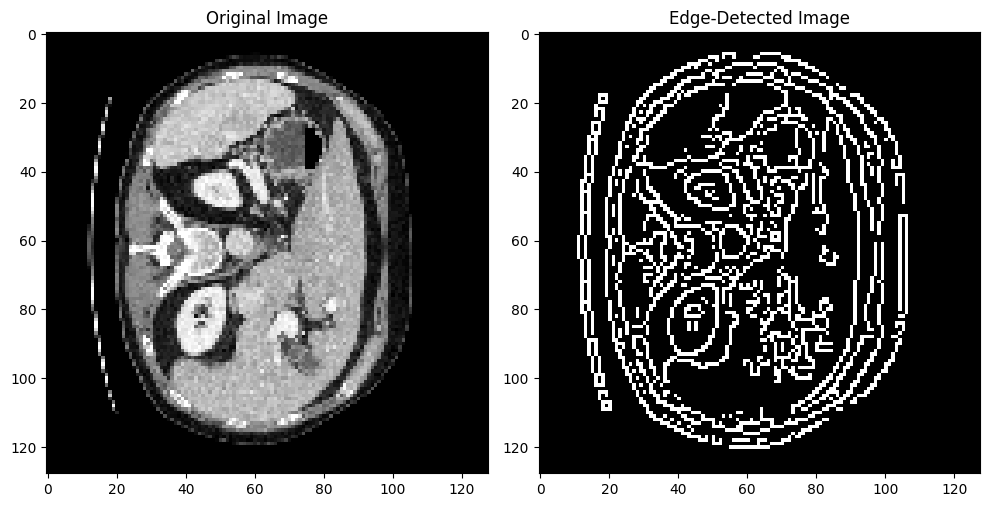

In [ ]:
import matplotlib.pyplot as plt

# Choose an image from your preprocessed dataset for visualization
sample_image = X_train_resized[0]

# Apply Canny edge detection
edges = cv2.Canny(sample_image, 100, 200)

# Display the original and edge-detected images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edge-Detected Image')

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Convert multi-channel label arrays to binary format
def convert_to_binary(labels):
    binary_labels = np.zeros((labels.shape[0], 1))
    for i in range(labels.shape[0]):
        if np.any(labels[i] > 0):  # Check if any value in the label array is above zero
            binary_labels[i] = 1    # Set as class 1 (cancerous feature) if any value is above zero
    return binary_labels

# Convert training and testing labels to binary format
Y_train_binary = convert_to_binary(Y_train_resized)
Y_test_binary = convert_to_binary(Y_test_resized)

# Define the CNN model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model with the converted binary labels
history = model.fit(X_train_resized, Y_train_binary, epochs=10, batch_size=32, validation_data=(X_test_resized, Y_test_binary))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_resized, Y_test_binary)
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
603/603 [==============================] - 17s 17ms/step - loss: 2.4635 - accuracy: 0.8031 - val_loss: 0.5307 - val_accuracy: 0.8372
Epoch 2/10
603/603 [==============================] - 10s 17ms/step - loss: 0.2051 - accuracy: 0.9132 - val_loss: 0.6058 - val_accuracy: 0.8518
Epoch 3/10
603/603 [==============================] - 9s 15ms/step - loss: 0.1584 - accuracy: 0.9326 - val_loss: 0.7657 - val_accuracy: 0.8408
Epoch 4/10
603/603 [==============================] - 10s 16ms/step - loss: 0.1392 - accuracy: 0.9421 - val_loss: 0.6926 - val_accuracy: 0.8477
Epoch 5/10
603/603 [==============================] - 10s 16ms/step - loss: 0.1170 - accuracy: 0.9525 - val_loss: 0.8412 - val_accuracy: 0.8485
Epoch 6/10
603/603 [==============================] - 10s 16ms/step - loss: 0.1009 - accuracy: 0.9584 - val_loss: 0.9627 - val_accuracy: 0.8333
Epoch 7/10
603/603 [==============================] - 10s 16ms/step - loss: 0.0991 - accuracy: 0.9589 - val_loss: 0.9500 - val_accuracy: 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Convert multi-channel label arrays to binary format
def convert_to_binary(labels):
    binary_labels = np.zeros((labels.shape[0], 1))
    for i in range(labels.shape[0]):
        if np.any(labels[i] > 0):  # Check if any value in the label array is above zero
            binary_labels[i] = 1    # Set as class 1 (cancerous feature) if any value is above zero
    return binary_labels

# Convert training and testing labels to binary format
Y_train_binary = convert_to_binary(Y_train_resized)
Y_test_binary = convert_to_binary(Y_test_resized)

# Define the CNN model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model with the converted binary labels
history = model.fit(X_train_resized, Y_train_binary, epochs=10, batch_size=32, validation_data=(X_test_resized, Y_test_binary))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_resized, Y_test_binary)
print(f'Test Accuracy: {accuracy}')


Epoch 1/10
603/603 [==============================] - 591s 977ms/step - loss: 3.1375 - accuracy: 0.8009 - val_loss: 0.3898 - val_accuracy: 0.8182
Epoch 2/10
603/603 [==============================] - 562s 931ms/step - loss: 0.2267 - accuracy: 0.9043 - val_loss: 0.4123 - val_accuracy: 0.8143
Epoch 3/10
603/603 [==============================] - 547s 906ms/step - loss: 0.1699 - accuracy: 0.9316 - val_loss: 0.3518 - val_accuracy: 0.8472
Epoch 4/10
603/603 [==============================] - 552s 916ms/step - loss: 0.1332 - accuracy: 0.9457 - val_loss: 0.3848 - val_accuracy: 0.8575
Epoch 5/10
603/603 [==============================] - 543s 900ms/step - loss: 0.1186 - accuracy: 0.9545 - val_loss: 0.4366 - val_accuracy: 0.8416
Epoch 6/10
603/603 [==============================] - 552s 915ms/step - loss: 0.1073 - accuracy: 0.9579 - val_loss: 0.4168 - val_accuracy: 0.8657
Epoch 7/10
603/603 [==============================] - 580s 962ms/step - loss: 0.0956 - accuracy: 0.9638 - val_loss: 0.4453 -

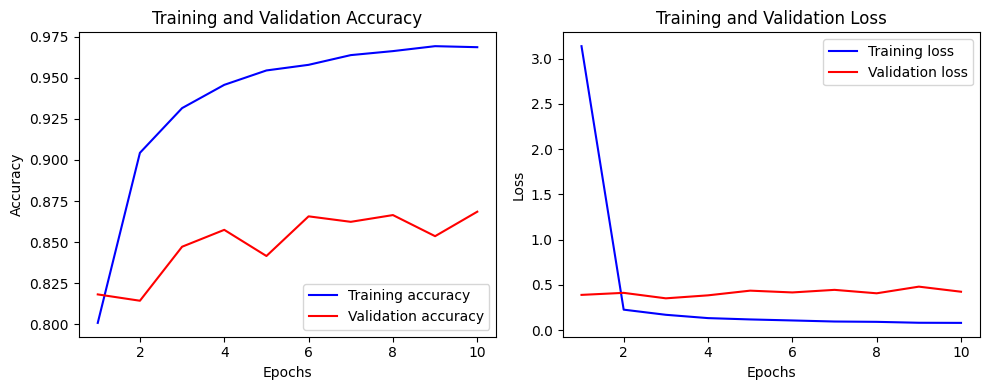

In [ ]:
import matplotlib.pyplot as plt

# Training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image as keras_image

# Load and preprocess the test image (adjust the path accordingly)
test_image_path = '/content/1.png'
test_image = keras_image.load_img(test_image_path, target_size=(128, 128))  # Resize to the model's input size
test_image = keras_image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)  # Add batch dimension

# Perform the prediction
prediction = model.predict(test_image)

# Convert prediction to class label (0: non-cancerous, 1: cancerous)
class_label = 'cancerous' if prediction > 0.5 else 'non-cancerous'
confidence = prediction[0][0] if prediction > 0.5 else 1 - prediction[0][0]

print(f'The predicted class is {class_label} with a confidence of {confidence:.2f}')


1/1 [==============================] - 0s 33ms/step
The predicted class is non-cancerous with a confidence of 1.00


1/1 [==============================] - 0s 252ms/step


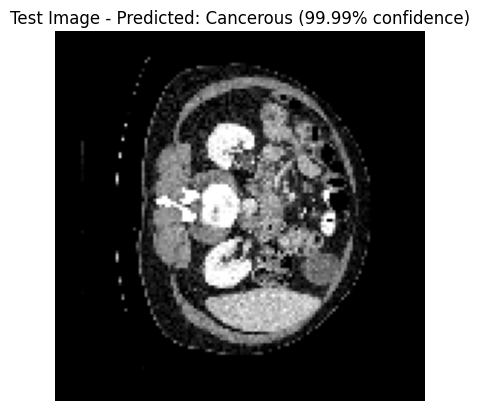

The predicted class is Cancerous with a confidence of 99.99%


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image as keras_image
import matplotlib.pyplot as plt

# Load and preprocess the test image (adjust the path accordingly)
test_image_path = '/content/29.png'
test_image = keras_image.load_img(test_image_path, target_size=(128, 128))  # Resize to the model's input size
test_image_array = keras_image.img_to_array(test_image)
test_image_array = np.expand_dims(test_image_array, axis=0)  # Add batch dimension

# Perform the prediction
prediction = model.predict(test_image_array)

# Convert prediction to class label (0: non-cancerous, 1: cancerous)
class_label = 'Cancerous' if prediction > 0.5 else 'Non-Cancerous'
confidence = prediction[0][0] if prediction > 0.5 else 1 - prediction[0][0]

# Visualize the input image
plt.imshow(test_image)
plt.title(f'Test Image - Predicted: {class_label} ({confidence:.2%} confidence)')
plt.axis('off')
plt.show()

print(f'The predicted class is {class_label} with a confidence of {confidence:.2%}')


1/1 [==============================] - 0s 18ms/step


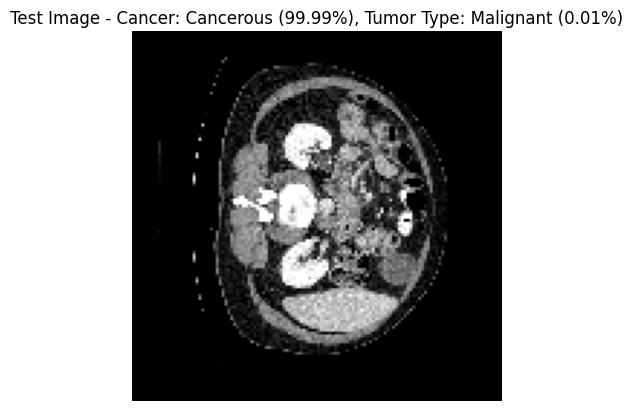

Cancer Prediction - Class: Cancerous, Confidence: 99.99%
Tumor Type Prediction - Class: Malignant, Confidence: 0.01%


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image as keras_image
import matplotlib.pyplot as plt

# Load and preprocess the test image (adjust the path accordingly)
test_image_path = '/content/29.png'
test_image = keras_image.load_img(test_image_path, target_size=(128, 128))  # Resize to the model's input size
test_image_array = keras_image.img_to_array(test_image)
test_image_array = np.expand_dims(test_image_array, axis=0)  # Add batch dimension

# Perform the prediction for cancer classification
cancer_prediction = model.predict(test_image_array)
cancer_class_label = 'Cancerous' if cancer_prediction > 0.5 else 'Non-Cancerous'
cancer_confidence = cancer_prediction[0][0] if cancer_prediction > 0.5 else 1 - cancer_prediction[0][0]

# Perform other predictions (modify this based on your model's architecture)
# Example: Let's say your model has another output for tumor type prediction
tumor_type_prediction = model.predict(test_image_array)
tumor_type_label = 'Benign' if tumor_type_prediction < 0.5 else 'Malignant'
tumor_type_confidence = tumor_type_prediction[0][0] if tumor_type_prediction < 0.5 else 1 - tumor_type_prediction[0][0]

# Visualize the input image
plt.imshow(test_image)
plt.title(f'Test Image - Cancer: {cancer_class_label} ({cancer_confidence:.2%}), Tumor Type: {tumor_type_label} ({tumor_type_confidence:.2%})')
plt.axis('off')
plt.show()

# Print predictions
print(f'Cancer Prediction - Class: {cancer_class_label}, Confidence: {cancer_confidence:.2%}')
print(f'Tumor Type Prediction - Class: {tumor_type_label}, Confidence: {tumor_type_confidence:.2%}')


In [ ]:
import zipfile
import os

# Specify the path to your zip file
zip_file_path = '/content/drive/MyDrive/yolo/archive (10).zip'

# Specify the directory where you want to extract the contents
extracted_dir = '/content/drive/MyDrive/yolo/extracted'

# Create the extraction directory if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# List the files in the extracted directory
extracted_files = os.listdir(extracted_dir)
print(f"Extracted files: {extracted_files}")

Extracted files: ['helmet.names', 'helmet_detection.jpg', 'yolov3-helmet.cfg', 'yolov3-helmet.weights']


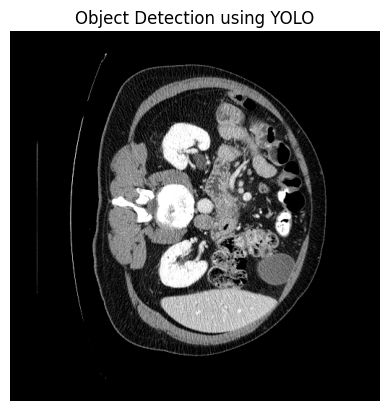

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the pre-trained YOLO model and configuration
net = cv2.dnn.readNet("/content/drive/MyDrive/yolo/extracted/yolov3-helmet.weights", "/content/drive/MyDrive/yolo/extracted/yolov3-helmet.cfg")
classes = []
with open("/content/drive/MyDrive/yolo/extracted/helmet.names", "r") as f:
    classes = [line.strip() for line in f]

# Load the image
image_path = "/content/29.png"
image = cv2.imread(image_path)
height, width, _ = image.shape

# Preprocess the image for YOLO
blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)

# Get output layer names
layer_names = net.getUnconnectedOutLayersNames()

# Run forward pass to get predictions
outs = net.forward(layer_names)

# Post-process the predictions
class_ids = []
confidences = []
boxes = []

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x, center_y, w, h = list(map(int, detection[0:4] * np.array([width, height, width, height])))
            x, y = int(center_x - w / 2), int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Apply non-maximum suppression to remove redundant overlapping boxes
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# Draw bounding boxes on the image
for i in indices:
    i = i[0]
    box = boxes[i]
    x, y, w, h = box
    label = str(classes[class_ids[i]])
    confidence = confidences[i]
    color = (0, 255, 0)  # Green color for bounding boxes
    cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
    cv2.putText(image, f'{label} {confidence:.2f}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Display the result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Object Detection using YOLO')
plt.axis('off')
plt.show()


In [ ]:
import cv2
import numpy as np

# Load YOLO
net = cv2.dnn.readNet("/content/drive/MyDrive/yolo/extracted/yolov3-helmet.weights", "/content/drive/MyDrive/yolo/extracted/yolov3-helmet.cfg")
classes = []
with open("/content/drive/MyDrive/yolo/extracted/helmet.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Load image
img = cv2.imread("/content/29.png")
height, width, _ = img.shape

# Preprocess image
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(net.getUnconnectedOutLayersNames())

# Get information about detected objects
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])

# Apply non-maximum suppression to remove overlapping boxes
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# Draw bounding boxes on the image
for i in indices:
    i = i[0]
    box = boxes[i]
    x, y, w, h = box
    label = str(classes[class_ids[i]])
    confidence = confidences[i]
    color = (0, 255, 0)  # Green color for the bounding box
    cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
    cv2.putText(img, f"{label} {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Display the result
cv2.imshow("YOLO Object Detection", img)
cv2.waitKey(0)
cv2.destroyAllWindows()


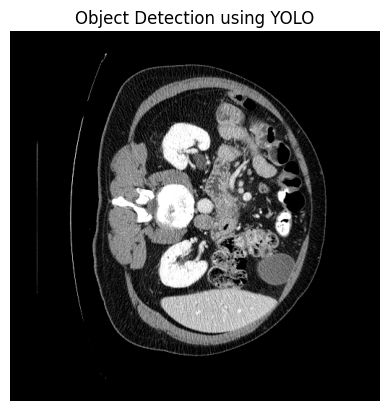

In [ ]:
# prompt: --------------------------------------------------------------------------- DisabledFunctionError                     Traceback (most recent call last) <ipython-input-29-eda51c073a73> in <cell line: 54>()      52       53 # Display the result ---> 54 cv2.imshow("YOLO Object Detection", img)      55 cv2.waitKey(0)      56 cv2.destroyAllWindows()  /usr/local/lib/python3.10/dist-packages/google/colab/_import_hooks/_cv2.py in wrapped(*args, **kwargs)      46   def wrapped(*args, **kwargs):      47     if not os.environ.get(env_var, False): ---> 48       raise DisabledFunctionError(message, name or func.__name__)      49     return func(*args, **kwargs)      50   DisabledFunctionError: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions to crash; see https://github.com/jupyter/notebook/issues/3935. As a substitution, consider using


# Load YOLO
net = cv2.dnn.readNet("/content/drive/MyDrive/yolo/extracted/yolov3-helmet.weights", "/content/drive/MyDrive/yolo/extracted/yolov3-helmet.cfg")
classes = []
with open("/content/drive/MyDrive/yolo/extracted/helmet.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Load image
img = cv2.imread("/content/29.png")
height, width, _ = img.shape

# Preprocess image
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(net.getUnconnectedOutLayersNames())

# Get information about detected objects
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])

# Apply non-maximum suppression to remove overlapping boxes
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# Draw bounding boxes on the image
for i in indices:
    i = i[0]
    box = boxes[i]
    x, y, w, h = box
    label = str(classes[class_ids[i]])
    confidence = confidences[i]
    color = (0, 255, 0)  # Green color for the bounding box
    cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
    cv2.putText(img, f"{label} {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Display the result
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Object Detection using YOLO')
plt.axis('off')
plt.show()



In [ ]:
pip install numpy matplotlib scikit-image opencv-python

In [ ]:
!pip install numpy matplotlib scikit-image opencv-python
!git clone https://github.com/ahmedfgad/Mask-RCNN-TF2.git
!cd Mask-RCNN-TF2

fatal: destination path 'Mask-RCNN-TF2' already exists and is not an empty directory.


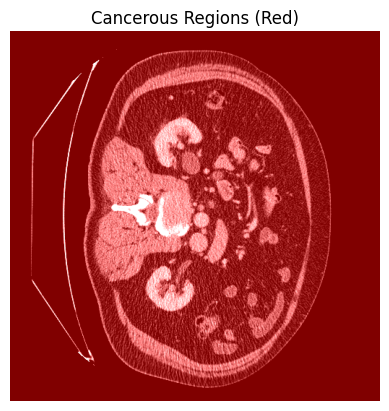

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load and preprocess the image
test_image_path = '/content/160.png'
original_image = cv2.imread(test_image_path)
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Assuming you have the model predictions available as feature_map (shape: same as the input image)
# Threshold the feature map to identify potential cancerous regions
threshold = 0.5  # Adjust as needed based on the model's output
binary_map = np.where(feature_map > threshold, 1, 0).astype(np.uint8)

# Resize the binary map to match the dimensions of the original image
binary_map_resized = cv2.resize(binary_map, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

# Threshold the binary map to highlight the potential cancerous regions
threshold = 0.5  # Set a threshold value to determine cancerous regions
potential_cancerous_regions = binary_map_resized > threshold

# Create a mask for the potential cancerous regions
mask = np.zeros_like(original_image)
mask[..., 0] = 255  # Set the red channel to 255 for potential cancerous regions
mask[potential_cancerous_regions] = [255, 0, 0]  # Mark potential cancerous regions in red

# Add the mask to the original image
colorized_image = cv2.addWeighted(original_image_rgb, 1, mask, 0.5, 0)

# Display the image with highlighted cancerous regions
plt.imshow(colorized_image)
plt.title('Cancerous Regions (Red)')
plt.axis('off')
plt.show()

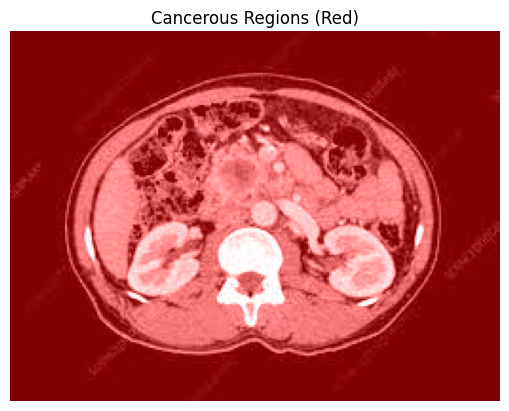

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
test_image_path = '/content/pancanpre.jpeg'
original_image = cv2.imread(test_image_path)
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Assuming you have the model predictions available as feature_map (same shape as the input image)
# Threshold the feature map to identify potential cancerous regions
threshold = 0.5  # Adjust as needed based on the model's output
binary_map = np.where(feature_map > threshold, 1, 0).astype(np.uint8)

# Resize the binary map to match the original image dimensions
binary_map_resized = cv2.resize(binary_map, (original_image.shape[1], original_image.shape[0]))

# Create a mask for the potential cancerous regions
mask = np.zeros_like(original_image_rgb)
mask[binary_map_resized == 1] = [255, 0, 0]  # Mark potential cancerous regions in red

# Add the mask to the original image
highlighted_image = cv2.addWeighted(original_image_rgb, 1, mask, 0.5, 0)

# Display the image with highlighted cancerous regions
plt.imshow(highlighted_image)
plt.title('Cancerous Regions (Red)')
plt.axis('off')
plt.show()


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Paths to image directories
base_dir = '/content/drive/MyDrive/Pancreas cancer/Images/Dataset'
X_train_dir = os.path.join(base_dir, 'X_train')
Y_train_dir = os.path.join(base_dir, 'Y_train')
X_test_dir = os.path.join(base_dir, 'X_test')
Y_test_dir = os.path.join(base_dir, 'Y_test')

In [ ]:


# Image dimensions
img_height, img_width = 128, 128
batch_size = 32

# Data generators for training and validation
def create_generator(directory, target_size=(img_height, img_width), batch_size=batch_size):
    data_gen = ImageDataGenerator(rescale=1./255)  # Rescale images

    generator = data_gen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        color_mode='rgb',
        shuffle=True
    )
    return generator

# Create generators for training and testing data
train_image_gen = create_generator(X_train_dir)
train_mask_gen = create_generator(Y_train_dir)
test_image_gen = create_generator(X_test_dir)
test_mask_gen = create_generator(Y_test_dir)



Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

def unet_model(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottom
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2, up1], axis=-1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1, up2], axis=-1)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)  # Single channel output for binary segmentation

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the U-Net model
unet = unet_model(input_shape=(128, 128, 3))
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
unet.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d_6[0][0]']            
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 64)           0         ['conv2d_7[0][0]']            
 g2D)                                                                                         

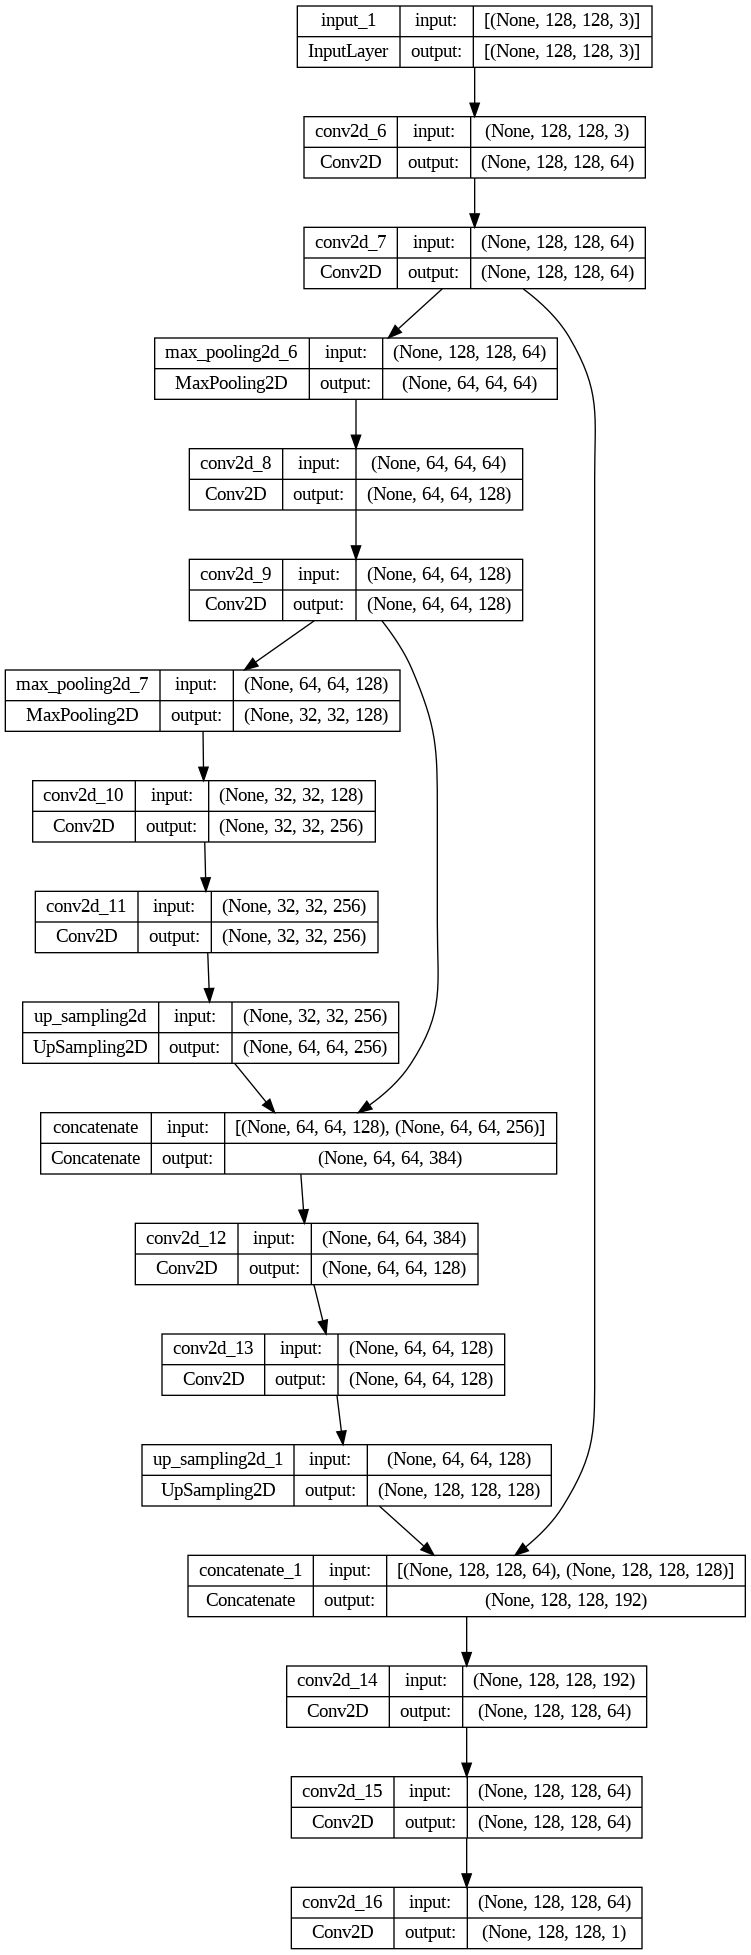

In [ ]:
from tensorflow.keras.utils import plot_model

# Visualize model architecture
plot_model(unet, to_file='unet_model.png', show_shapes=True, show_layer_names=True)


In [ ]:
import matplotlib.pyplot as plt
history = unet.fit(train_image_gen, train_mask_gen, epochs=10, validation_data=(test_image_gen, test_mask_gen))

# Assuming 'history' contains the training history
plt.figure(figsize=(10, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()


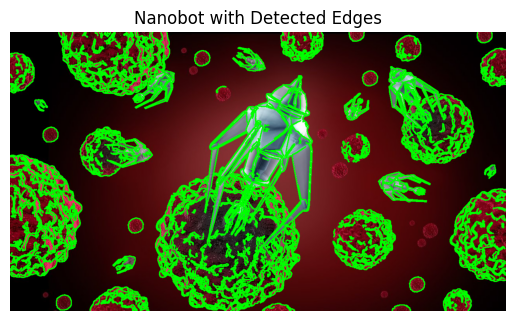

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/Nanorobots_0.jpg'
image = cv2.imread(image_path)

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur for noise reduction (optional)
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

# Apply Canny edge detection
edges = cv2.Canny(blurred_image, 50, 150)  # Adjust thresholds accordingly

# Find contours to analyze shapes
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Analyze shapes (for example, draw contours)
cv2.drawContours(image, contours, -1, (0, 255, 0), 2)  # Draw contours on the original image

# Display the processed image with detected edges
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Nanobot with Detected Edges')
plt.axis('off')
plt.show()


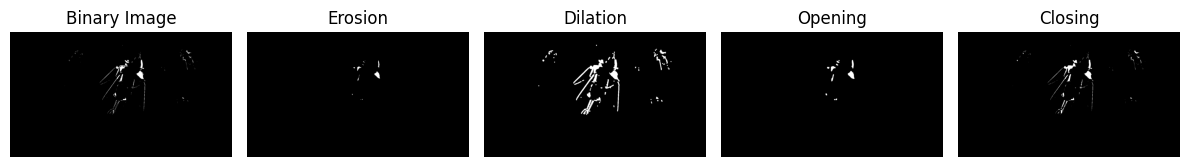

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the nanobot image
image_path = '/content/Nanorobots_0.jpg'
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to create a binary image (convert to black and white)
_, binary_image = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)

# Apply morphology operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

# Erosion - Shrinks bright regions (foreground)
eroded_image = cv2.erode(binary_image, kernel, iterations=1)

# Dilation - Expands bright regions (foreground)
dilated_image = cv2.dilate(binary_image, kernel, iterations=1)

# Opening - Erosion followed by dilation, useful for noise reduction
opening_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

# Closing - Dilation followed by erosion, useful for closing small holes
closing_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

# Display the images
plt.figure(figsize=(12, 4))

plt.subplot(151)
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image')
plt.axis('off')

plt.subplot(152)
plt.imshow(eroded_image, cmap='gray')
plt.title('Erosion')
plt.axis('off')

plt.subplot(153)
plt.imshow(dilated_image, cmap='gray')
plt.title('Dilation')
plt.axis('off')

plt.subplot(154)
plt.imshow(opening_image, cmap='gray')
plt.title('Opening')
plt.axis('off')

plt.subplot(155)
plt.imshow(closing_image, cmap='gray')
plt.title('Closing')
plt.axis('off')

plt.tight_layout()
plt.show()


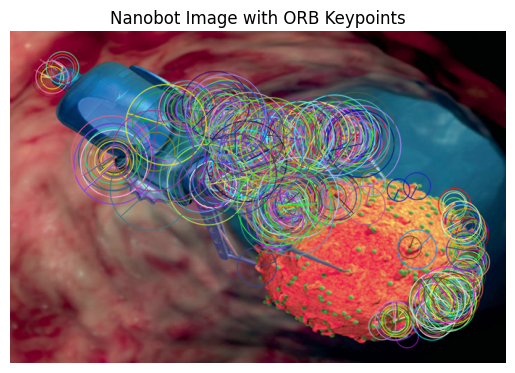

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the nanobot image
image_path = '/content/Nanobot.png'
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Initialize ORB detector
orb = cv2.ORB_create()

# Detect keypoints and compute descriptors
keypoints, descriptors = orb.detectAndCompute(gray_image, None)

# Draw keypoints on the image
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the image with keypoints
plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Nanobot Image with ORB Keypoints')
plt.axis('off')
plt.show()


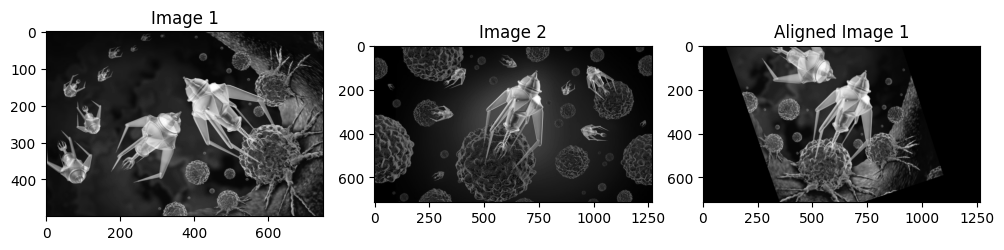

(None, None)

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load two nanobot images
image_path_1 = '/content/Nanorobots-1.jpg'
image_path_2 = '/content/Nanorobots_0.jpg'
image1 = cv2.imread(image_path_1, 0)  # Load as grayscale
image2 = cv2.imread(image_path_2, 0)  # Load as grayscale

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and descriptors
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# Match descriptors between the images
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

# Ratio test to select good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Get corresponding points
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Calculate perspective transformation matrix using RANSAC
M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Apply perspective transformation to align images
aligned_image = cv2.warpPerspective(image1, M, (image2.shape[1], image2.shape[0]))

# Display aligned images
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1), plt.imshow(image1, cmap='gray'), plt.title('Image 1')
plt.subplot(1, 3, 2), plt.imshow(image2, cmap='gray'), plt.title('Image 2')
plt.subplot(1, 3, 3), plt.imshow(aligned_image, cmap='gray'), plt.title('Aligned Image 1')
plt.tight_layout(), plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=True)

# Define a function to preprocess the input image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# Nanobot image path for classification
nanobot_image_path = '/content/nano2.jpg'

# Preprocess the nanobot image
preprocessed_image = preprocess_image(nanobot_image_path)

# Predict the class probabilities for the image
predictions = model.predict(preprocessed_image)

# Decode the predictions
decoded_predictions = decode_predictions(predictions, top=3)[0]

# Display the top predicted classes
for _, class_name, class_score in decoded_predictions:
    print(f'{class_name.capitalize()}: {class_score:.2f}')


1/1 [==============================] - 1s 754ms/step
Bubble: 0.86
Balloon: 0.11
Hook: 0.00


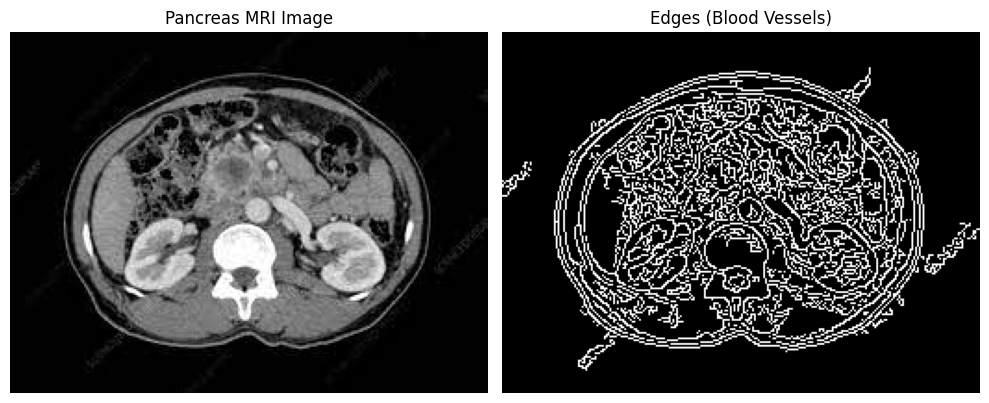

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Read the pancreas MRI image
pancreas_image = cv2.imread('/content/pancanpre.jpeg', 0)  # Read as grayscale

# Apply Canny edge detection
edges = cv2.Canny(pancreas_image, 30, 150)  # Adjust thresholds as needed

# Display original image and edges
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(pancreas_image, cmap='gray')
plt.title('Pancreas MRI Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edges (Blood Vessels)')
plt.axis('off')

plt.tight_layout()
plt.show()


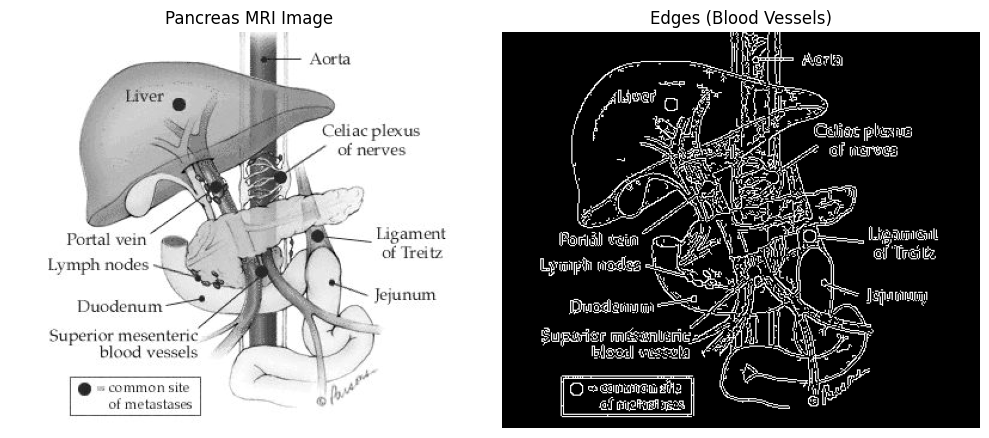

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Read the pancreas MRI image
pancreas_image = cv2.imread('/content/pancreas1.jpg', 0)  # Read as grayscale

# Apply Canny edge detection
edges = cv2.Canny(pancreas_image, 30, 150)  # Adjust thresholds as needed

# Display original image and edges
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(pancreas_image, cmap='gray')
plt.title('Pancreas MRI Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edges (Blood Vessels)')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# prompt:  No module named 'SimpleITK'

!pip install SimpleITK


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 14.5 MB/s eta 0:00:00


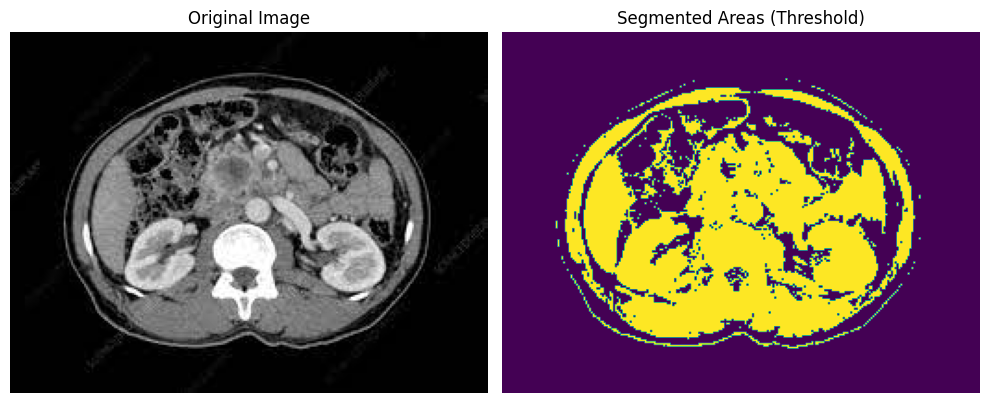

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the JPEG image
image_path = '/content/pancanpre.jpeg'  # Replace with the path to your JPEG image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale

# Apply simple thresholding
threshold_value = 100
_, binary_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)

# Display original and segmented areas
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_image, cmap='viridis')
plt.title('Segmented Areas (Threshold)')
plt.axis('off')

plt.tight_layout()
plt.show()

plt.show()

